In [36]:
import numpy as np
import pandas as pd
from copy import deepcopy as dc
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import lifelines.datasets
import torch
import torchtuples as tt
from pycox.models import CoxPH, CoxTime
from pycox.models.cox_time import MLPVanillaCoxTime
from pycox.evaluation import EvalSurv
from sklearn.model_selection import train_test_split
np.random.seed(1998)
_ = torch.manual_seed(1998)

In [37]:
df = pd.read_csv("data_ready_45.csv")

In [38]:
df_train, df_val_test = train_test_split(df, test_size=0.3, random_state=654)
df_val, df_test = train_test_split(df_val_test, test_size=0.5, random_state=654)

In [39]:
ssc = StandardScaler()
x_train = ssc.fit_transform(df_train.drop(columns=['time_frame', 'GRF_STAT_PA'])).astype('float32')
x_val = ssc.transform(df_val.drop(columns=['time_frame', 'GRF_STAT_PA'])).astype('float32')
x_test = ssc.transform(df_test.drop(columns=['time_frame', 'GRF_STAT_PA'])).astype('float32')

In [40]:
get_target = lambda df: (df['time_frame'].values, df['GRF_STAT_PA'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)
val = x_val, y_val

In [41]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False
net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

c:\Users\Omar\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchtuples\base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch

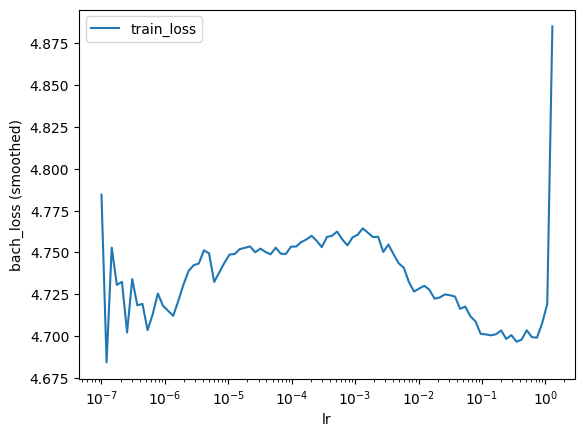

In [42]:
model = CoxPH(net, tt.optim.Adam)
batch_size = 256
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()

In [43]:
lrfinder.get_best_lr()

0.0001

In [54]:
model.optimizer.set_lr(0.0001)

In [55]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

13:	[0s / 0s],		train_loss: 4.5211,	val_loss: 4.4722
14:	[0s / 0s],		train_loss: 4.5246,	val_loss: 4.4716
15:	[0s / 1s],		train_loss: 4.5228,	val_loss: 4.4719
16:	[0s / 1s],		train_loss: 4.5202,	val_loss: 4.4708
17:	[0s / 1s],		train_loss: 4.5199,	val_loss: 4.4709
18:	[0s / 2s],		train_loss: 4.5186,	val_loss: 4.4704
19:	[0s / 2s],		train_loss: 4.5192,	val_loss: 4.4702
20:	[0s / 3s],		train_loss: 4.5173,	val_loss: 4.4702
21:	[0s / 3s],		train_loss: 4.5197,	val_loss: 4.4700
22:	[0s / 4s],		train_loss: 4.5220,	val_loss: 4.4701
23:	[0s / 4s],		train_loss: 4.5199,	val_loss: 4.4699
24:	[0s / 4s],		train_loss: 4.5204,	val_loss: 4.4697
25:	[0s / 5s],		train_loss: 4.5206,	val_loss: 4.4695
26:	[0s / 5s],		train_loss: 4.5160,	val_loss: 4.4695
27:	[0s / 6s],		train_loss: 4.5258,	val_loss: 4.4691
28:	[0s / 6s],		train_loss: 4.5223,	val_loss: 4.4692
29:	[0s / 6s],		train_loss: 4.5180,	val_loss: 4.4689
30:	[0s / 7s],		train_loss: 4.5177,	val_loss: 4.4688
31:	[0s / 7s],		train_loss: 4.5145,	val_loss: 

c:\Users\Omar\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchtuples\base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch

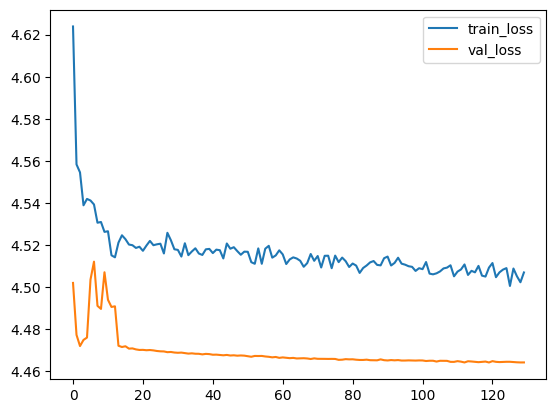

In [56]:
_ = log.plot()

In [57]:
model.partial_log_likelihood(*val).mean()

-7.472692

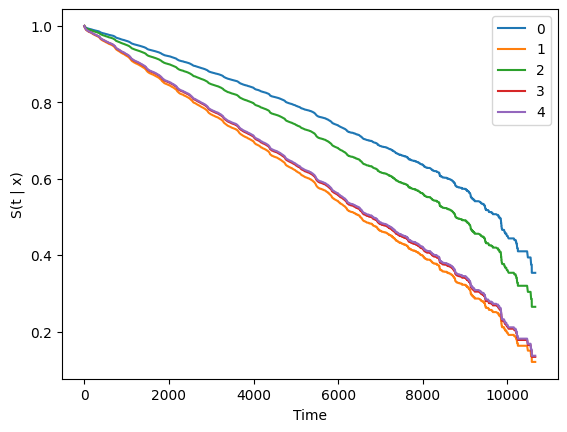

In [58]:
_ = model.compute_baseline_hazards()
surv = model.predict_surv_df(x_test)
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [59]:
df.loc[df_test.index[:5]]

,GENDER,PERIP_VASC,AGE_DIAB,CREAT_TRR,AMIS,BMIS,DRMIS,HLAMIS,NPKID,NPPAN,...,MED_COND_TRR_is3,MALIG,HGT_CM_CALC,WGT_KG_CALC,BMI_CALC,PROTEIN_URINE,CARDARREST_NEURO,RESUSCIT_DUR,INOTROP_SUPPORT_DON,time_frame
11491,0.0,1.0,21.0,3.50,1.0,1.0,1.0,3.0,0.0,0.0,...,1.0,0.0,182.0,83.8,25.3,0.0,0.0,0.0,0.0,8193.0
14807,1.0,0.0,8.0,4.00,1.0,2.0,1.0,4.0,0.0,0.0,...,1.0,0.0,155.0,53.0,22.1,0.0,0.0,0.0,1.0,1519.0
12085,0.0,0.0,22.0,5.22,1.0,2.0,1.0,4.0,0.0,0.0,...,1.0,0.0,170.0,63.5,22.0,0.0,0.0,0.0,0.0,3048.0
24113,1.0,0.0,10.0,3.16,2.0,1.0,1.0,4.0,0.0,0.0,...,1.0,0.0,172.7,75.3,25.2,0.0,1.0,20.0,0.0,3691.0
13828,1.0,0.0,12.0,11.50,2.0,2.0,2.0,6.0,0.0,0.0,...,1.0,0.0,168.0,65.0,23.0,0.0,0.0,0.0,0.0,2640.0


In [60]:
_ = model.compute_baseline_hazards()
surv = model.predict_surv_df(x_test)

In [61]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [63]:
ev.concordance_td()

0.6666342092270557

In [68]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)

In [70]:
ev.integrated_brier_score(time_grid=time_grid)

0.1767079168344688